**IMPORTO LIBRERIAS**

In [4]:
## modulo para manipulacion de ubicacion de datos
import os

## modules para manipulacion de datos
import pandas as pd
import numpy as np

## modulos para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

## modulos para procesamiento de texto
!pip install nltk
import nltk
import re
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
!pip install unidecode
from unidecode import unidecode

## modulos para deteccion de idioma
!pip install langdetect
import langdetect

## modulo para vectorizacion
from sklearn.feature_extraction.text import TfidfVectorizer

## modulos para clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#ignorar "future warnings"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to /home/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eric/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**FUNCIONES A USAR**

In [5]:
def df_conversaciones(path = 'Ejercicio/corpus/'):
    """
    Carga los csv de conversaciones
    y los concatena en un dataframe 
    """
    df = pd.DataFrame(columns=['text', 'file'])
    for file in os.listdir(path):
        if file.endswith('.csv'):
            with open(path+file, 'r', encoding='utf-8') as f:
                text = f.read()
                df = df.append({'text': text, 'file': file}, ignore_index=True)
    return df
            
def lista_remove_words():
    """
    Crea una lista de palabras a remover
    """
    remove_words = stopwords.words("spanish")
    remove_words.extend(['hola','gracias','gusto','saludo','si', 'entonces','perfecto','buenas','muchas','bien','claro','bueno','sabes','numero','usted','correcto','pedido','hacer','luego','va', 'pregunta', 'cero'])
    return remove_words

def preprocess_text(text, remove_words = lista_remove_words(),nlp = spacy.load("es_core_news_sm")):
    """
    Preprocesa el texto, eliminando caracteres especiales,
    stopwords, remueve numeros, pronombres, adverbios, etc.
    (ver lista en tokens adentro de la funcion)
    Lematiza y elimina palabras de la lista
    remove_words, y devuelve el texto preprocesado.
    La funcion tambien cuenta la cantidad de textos
    preprocesados.
    """
    text = unidecode(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.pos_ in ['NUM', 'SYM', 'PUNCT', 'SPACE', 'X', 'PRON', 'DET', 'CCONJ', 'ADP', 'AUX', 'SCONJ', 'PART', 'INTJ', 'ADV', 'PROPN']]
    tokens = [w for w in tokens if not w.lower() in remove_words]
    tokens = [nlp(w)[0].lemma_ for w in tokens]
    text = " ".join(tokens)
    global counter
    counter += 1
    print('texto preprocesado #', counter, '\r', end='')
    return text

def vectorizacion(df,campo_preprocesado = 'text_clean'):
    """
    Vectoriza los textos preprocesados con TF-IDF,
    y devuelve el array de vectores.
    """
    print('\nAplico TF-IDF a las conversaciones preprocesadas')
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    X = vectorizer.fit_transform(df[campo_preprocesado])
    return X, vectorizer

def clustering(X):
    """
    Realiza clustering con K-Means,
    devuelve los tres clusters.
    """
    print('\nUtilizo algoritmo K-Means, agrupo conversaciones en 3 clusters.')
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X)
    clusters = kmeans.labels_
    return clusters

def PCA_clusters(X):
    """
    Realiza PCA con 2 componentes,
    devuelve los vectores reducidos.
    """
    print('\nAplico PCA para reducir dimensionalidad y poder graficar distribucion de conversaciones')
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(X.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    return x0, x1

def top_palabras_cluster(X, vectorizer, clusters):
    """
    Devuelve las 10 palabras con mayor TF-IDF
    para cada cluster.
    """
    df = pd.DataFrame(X.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names_out()
    print('\nTop 10 palabras por cluster:')
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-10:]]))

def asigno_clusters(df, X):
    """
    Asigna los clusters y los vectores reducidos
    al dataframe.
    """
    clusters = clustering(X)
    x0, x1 = PCA_clusters(X)
    df['cluster'] = clusters
    df['x0'] = x0
    df['x1'] = x1
    return df

def nombro_clusters(df):
    """
    Asigna un nombre a cada cluster.
    """
    cluster_map = {0: 'ayuda', 1: 'envios', 2: 'compra'}
    print(f'\nSegun el top 10 de palabras por cluster, se asigna un nombre a cada cluster: {cluster_map}')
    df['cluster'] = df['cluster'].map(cluster_map)
    return df

def grafico_clusters(df):
    """
    Grafica los clusters en un scatterplot.
    """
    print('\nGrafico clusters')
    plt.figure(figsize=(8, 5))
    plt.title('TF-IDF + KMeans + PCA')
    plt.xlabel('x0')
    plt.ylabel('x1')
    sns.scatterplot(x='x0', y='x1', hue='cluster', data=df, palette='plasma')
    plt.show()

def main(path  = 'Ejercicio/corpus/'):
    """
    Funcion principal que ejecuta todas las funciones
    y devuelve el dataframe con los clusters y los
    vectores reducidos. Devuelve un dataframe con
    las conversaciones y su cluster asignado.
    """
    print('inicio funcion main \n')
    df = df_conversaciones(path)
    global counter
    counter = 0
    df['text_clean'] = df['text'].map(preprocess_text)
    X, vectorizer = vectorizacion(df)
    clusters = clustering(X)
    top_palabras_cluster(X, vectorizer, clusters)
    df = asigno_clusters(df, X)
    df = nombro_clusters(df)
    df_final = df[['text','file', 'cluster']]
    grafico_clusters(df)
    df_final.to_csv(path+'df_clusters.csv', index=False)

Para correr la funcion `main` de la siguiente celda, tener en cuenta que la misma necesita
un path de entrada que contenga la carpeta donde están guardados los 640 archivos .csv y devuelve un dataframe
con los textos y sus grupos asignados en el mismo path.
Por default, el path de entrada es `'Ejercicio/corpus/'`. Si se quiere cambiar, modificar la variable.

inicio funcion main 

texto preprocesado # 640 
Aplico TF-IDF a las conversaciones preprocesadas

Utilizo algoritmo K-Means, agrupo conversaciones en 3 clusters.

Top 10 palabras por cluster:

Cluster 0
esperar,ayudar,él,diar,tarde,punto,verificar,momento,indicar,favor

Cluster 1
cosa,producto,querer,tarde,manán,ver,diar,hacer,decir,llegar

Cluster 2
contar,banco,peso,vez,pagar,decir,hacer,compra,credito,tarjeta

Utilizo algoritmo K-Means, agrupo conversaciones en 3 clusters.

Aplico PCA para reducir dimensionalidad y poder graficar distribucion de conversaciones

Segun el top 10 de palabras por cluster, se asigna un nombre a cada cluster: {0: 'ayuda', 1: 'envios', 2: 'compra'}

Grafico clusters


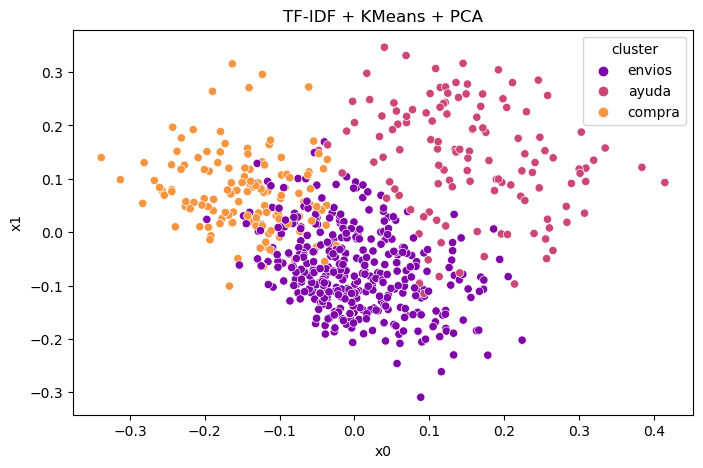

In [6]:
main()

Comentarios a modo de cierre: hice varias pruebas con este algoritmo, acorde veía las palabras más frecuentes de los clusters, fui agregando palabras
para filtrar en remove_words así podíá obtener resultados más representativos. Obtuve 3 clusters que pueden identificarse fácilmente en el gráfico.
